In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

from neural_network import NeuralNetwork
from methods import *
from data_gen import Poly1D2Deg, FrankeDataGen, CancerData
from iristest import test_iris

np.random.seed(4155) # FYS-STK4155 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#test_iris()

In [3]:
data = FrankeDataGen(noise=False)

In [4]:
inputs = jnp.column_stack((data.x.flatten(), data.y.flatten()))  
targets = data.z.ravel().reshape(-1, 1)                          

In [5]:
input_size = 2
output_size = 1
hidden_layers = [32, 16, 8]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["ReLU", "sigmoid", "ReLU", "identity"]
cost_fun = mse

epochs = 30
learning_rate = 0.001
batch_size = 1000

In [6]:
grad_methods = ["Constant", "Momentum","Adagrad_Momentum", "Adam", "RMSprop", "Adagrad"]
losses = []
accuracies = []

for grad in tqdm(grad_methods):
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "regression", grad)
    _, accuracy_list, loss_list, preds = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)

  0%|          | 0/6 [00:00<?, ?it/s]

Using jax grad


 17%|█▋        | 1/6 [00:02<00:13,  2.69s/it]

Using jax grad


 33%|███▎      | 2/6 [00:04<00:08,  2.23s/it]

Using jax grad


 50%|█████     | 3/6 [00:06<00:06,  2.24s/it]

Using jax grad


 67%|██████▋   | 4/6 [00:08<00:04,  2.19s/it]

Using jax grad


 83%|████████▎ | 5/6 [00:10<00:02,  2.11s/it]

Using jax grad


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


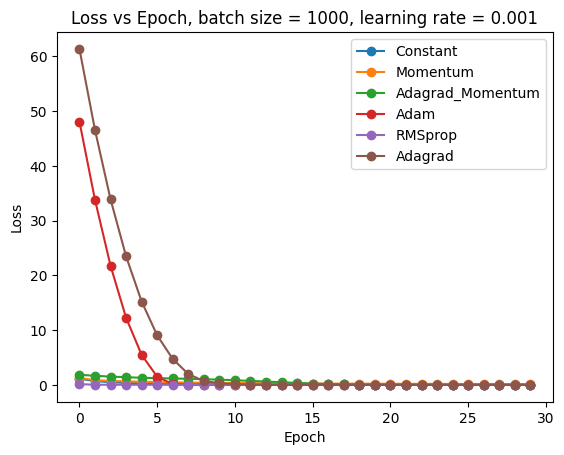

In [10]:
i = 0

for method, loss_list in zip(grad_methods, losses):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list, label=method, marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

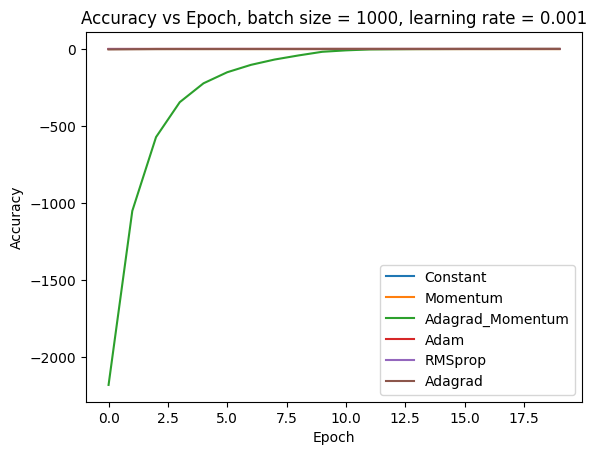

In [11]:
i = 0
for method, accuracy_list in zip(grad_methods, accuracies):
    if i in [0, 1,2, 3,4,5]:
        plt.plot(accuracy_list[10:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()